In [1]:
#-*- coding: utf-8 -*-

<img align="right" style="max-width: 200px; height: auto" src="hsg_logo.png">

###  Lab 04 - "Unsupervised Machine Learning"

Introduction to AI and ML, University of St. Gallen, Autumn Term 2019

In the last lab you learned about how to utilize two **supervised** learning classification techniques namely (1) the Gaussian Naive-Bayes (Gaussian NB) classifier and (2) the k Nearest-Neighbor (kNN) classifier. 

In this fourth lab we will learn about two **unsupervised** machine learning technique referred to as **k-Means Clustering** and **Expectation-Maximization (EM) Clustering**. We will use this technique to classify un-labelled data (i.e., data without defined categories or groups). In general, clustering-based techniques are widely used in **unsupervised machine learning**.

<img align="center" style="max-width: 500px" src="machinelearning.png">

The **k-Means Clustering** algorithm is one of the most popular clustering algorithms used in machine learning. The goal of k-Means Clustering is to find groups (clusters) in a given dataset. It can be used (1) to **confirm business assumptions** about what types of groups exist or (2) to **identify unknown groups** in complex data sets. Some examples of business-related use cases are:

>- Segment customers by purchase history;
>- Segment users by activities on an application or a website;
>- Group inventory by sales activity; or,
>- Group inventory by manufacturing metrics.

(Source: https://www.datascience.com/blog/k-means-clustering)

Once the algorithm has been run and the groups are defined, any new data can be easily assigned to the correct group.

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

### Lab Objectives:

After today's lab, you should be able to:

> 1. Understand how a **k-Means Clustering** algorithm can be trained and evaluated.
> 2. Know how to Python's **sklearn library** to train and evaluate arbitrary classifiers.
> 3. Understand how to evaluate the **classification results** of the k-Means algorithm.
> 4. Know how to select an **optimal number of clusters** or cluster means.

### Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will be using pandas, numpy, sklearn, matplotlib and seaborn library to conduct this:

In [2]:
# import the pandas data science library
import pandas as pd
import numpy as np

# import the scipy spatial distance capability
from scipy.spatial.distance import cdist

# import sklearn data and data pre-processing libraries
from sklearn import datasets
from sklearn.datasets.samples_generator import make_blobs

# import sklearn k-means classifier library
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# import matplotlib data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import matplotlibs 3D plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

Create nice looking plots using the **seaborn** plotting theme:

In [3]:
plt.style.use('seaborn')

Enable inline Jupyter notebook plotting:

In [4]:
%matplotlib inline

Suppress potential warnings:

In [5]:
import warnings
warnings.filterwarnings('ignore')

Set random seed of all our experiments:

In [6]:
random_seed = 42

## 1. Unsupervised Machine Learning: k-Means Clustering

### 1.1. Dataset Download and Data Assessment

The iris dataset is a classic and very easy multi-class classification dataset. This dataset consists of 3 different types of irises’ (classes),  namely Setosa, Versicolour, and Virginica) as well as their respective petal and sepal length (features). In total, the dataset consists of **150 samples** (50 samples per class) as well as their corresponding **4 different measurements** taken for each sample. 

<img align="center" style="max-width: 700px; height: auto" src="iris_dataset.png">

(Source: http://www.lac.inpe.br/~rafael.santos/Docs/R/CAP394/WholeStory-Iris.html)

Please, find below the list of the individual measurements (features):

>- `Sepal length (cm)`
>- `Sepal width (cm)`
>- `Petal length (cm)`
>- `Petal width (cm)`

Further details on the dataset can be obtained from the following publication: *Fisher, R.A. "The use of multiple measurements in taxonomic problems" Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions to Mathematical Statistics" (John Wiley, NY, 1950)."*

Let's load the dataset and conduct a preliminary data assessment: 

In [7]:
iris = datasets.load_iris()

Print and inspect feature names of the dataset:

In [8]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Print and inspect the class names of the dataset:

In [9]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Print and inspect the top 5 feature rows of the dataset:

In [10]:
pd.DataFrame(iris.data).head(5)

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Print and inspect the top 5 labels of the dataset:

In [11]:
pd.DataFrame(iris.target).head(5)

,0
0,0
1,0
2,0
3,0
4,0


Determine and print the feature dimensionality of the dataset:

In [12]:
iris.data.shape

(150, 4)

Determine and print the label dimensionality of the dataset:

In [13]:
iris.target.shape

(150,)

Let's briefly envision how the feature data is collected and recorded in the data:

<img align="center" style="max-width: 900px; height: auto" src="featurecollection.png">

Plot the data distributions of the distinct features:

<Figure size 720x720 with 0 Axes>

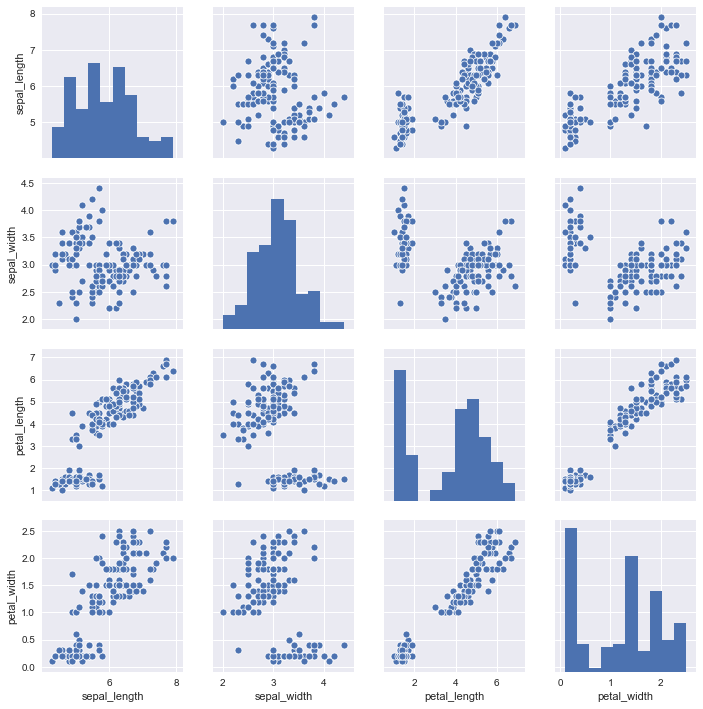

In [63]:
plt.figure(figsize=(10, 10))
iris_plot = sns.load_dataset("iris")

# supervised scenario
#sns.pairplot(iris_plot, diag_kind='hist', hue='species');

# unsupervised scenario
sns.pairplot(iris_plot, diag_kind='hist');

Now imagine that we did not have the convenient `species` (class) label associated with each observation in the iris dataset. **How could we distinguish the three species in the dataset?**

### 1.2. The k-Means Clustering Algorithm

As already mentioned the **k-Means Clustering** algorithm is one of the most popular "first choice" unsupervised clustering algorithms to find groups (clusters) in a given multidimensional dataset $X$.

<img align="center" style="max-width: 400px; height: auto" src="kmeans.png">

Thereby, the basic form of k-Means Clustering makes the following **two assumptions**:

- Each observation is closer to its own cluster center than to the center of the other clusters.
- A cluster center is the arithmetic mean of all the points that belong to the cluster.

Let's briefly revisit the distinct step of the algorithm before applying it to the iris dataset. Therefore, let's assume:

- We have dataset $X$ consisting records $x_1, x_2, x_3, ..., x_n \in \mathcal{R}^d$; 
- That samples are clustered around $k$ centers (the "$k$ means") denoted by $\mu_1, \mu_{2}, ..., \mu_{k} \in \mathcal{R}^d$; and,
- Each sample $x_{i}$ belongs to its closest mean $\mu_{i}$.

We can then iteratively perform the following steps that comprise the **k-Means Clustering** algorithm:

>- **Step 1** - Pick $k$ random points $\mu_{i}$ as cluster centres called 'means'.
>- **Step 2** - Assign each $x_i$ to its to nearest cluster mean by calculating its distance to each mean.
>- **Step 3** - Determine the new cluster centres by calculating the average of the assigned points in each cluster.
>- **Step 4** - Repeat Step 2 and 3 until none of the cluster assignments change.

Note, that a single execution of all the four steps outlined above is usually referred to as 'iteration'.

### 1.3. k-Means Clustering in a 2-Dimensional Feature Space

Now, let's see how we can apply it to the iris dataset. We will start with an introductory example of detecting the classes of the iris dataset based on two of its features namely the (1) `Petal length (cm)` and (2) `Petal width (cm)`. Let's first gain an intuition of those two features as well as their distribution by visualizing them accordingly:

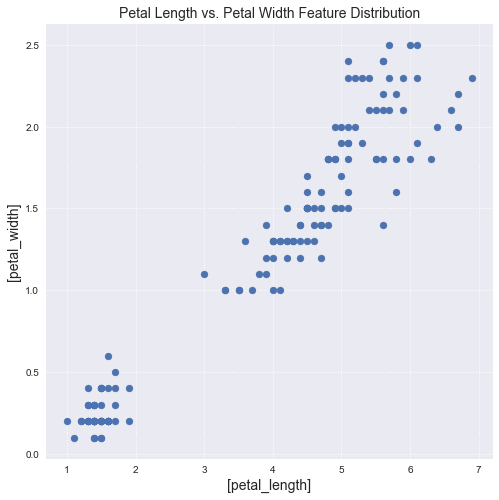

In [15]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length (3rd feature in the dataset) vs. petal width (4th feature in the dataset)
ax.scatter(iris.data[:,2], iris.data[:,3])

# add axis legends
ax.set_xlabel("[petal_length]", fontsize=14)
ax.set_ylabel("[petal_width]", fontsize=14)

# add plot title
plt.title('Petal Length vs. Petal Width Feature Distribution', fontsize=14);

Let's now define the parameters of the k-Means Clustering. We will start by specifying the **number of clusters** $k$ we aim to detect in the iris dataset. We hypothesize that our observations are drawn from an unknown distributions of three iris flower species (each distribution corresponding to a different mean $\mu_1$, $\mu_2$, and, $\mu_3$). Therefore, we set the number of clusters to be detected to $k=3$:

In [16]:
no_clusters = 3

Next, we need to define a corresponding number of **initial 'means' $\mu_{i}$** (the initial random cluster centers) that will be used as 'starting points' in the first iteration of the clustering process. In our case we will specify $k=3$ cluster means each of dimension 2, since we aim to retrieve 3 clusters based on the 2 features `Petal length (cm)` and `Petal width (cm)`:

In [17]:
init_means = np.array([[1.0, 3.0], [2.0, 6.0], [1.0, 7.0]])

Finally, we will define a **maximum number of iterations** that we want to run the k-Means Clustering algorithm. Please, note that the clustering terminates once there will be no further changes in the cluster assignments. However, it's good practice to define an upper bound of the iterations applied in the clustering (especially when analyzing datasets that exhibt a high-dimensional feature space):

In [18]:
max_iterations = 10

Now, we ready to initialize an instance of the **k-Means Clustering** algorithm using Python's `sklearn` library of data science algorithms:

In [19]:
kmeans = KMeans(n_clusters=no_clusters, init=init_means, max_iter=max_iterations)

Let's run the k-Means Clustering to learn a model of the `Petal length (cm)` and  `Petal width (cm)` features. Pls. note that we are using columns 2 and 3 to extract the values of the two features from the iris dataset:

In [20]:
kmeans.fit(iris.data[:,2:4]) # note that we are using column 2 (petal length) and 3 (petal width) 

KMeans(algorithm='auto', copy_x=True,
       init=array([[1., 3.],
       [2., 6.],
       [1., 7.]]), max_iter=10,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Now that we have conducted the clustering, let's inspect the distinct cluster labels that have been assigned to the individual records of the iris dataset. This can be achieved by calling the `labels_` attribute of the fitted model: 

In [21]:
labels = kmeans.labels_ # obtain the assigned cluster labels
print(labels)           # print the cluster labels

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1]


Furthermore, we want to inspect the coordinates of the cluster means (sometimes also referred to as "centroids") assigned by the algorithm. This can be achieved by calling the `cluster_centers_`attribute of the fitted model:

In [22]:
means = kmeans.cluster_centers_ # obtain the assigned cluster means 
print(means)                    # print the cluster center coordinates

[[1.462      0.246     ]
 [5.63777778 2.06      ]
 [4.30727273 1.36181818]]


Let's now plot the iris dataset records using the two features `Petal length (cm)` and `Petal width (cm)` as well as the labels and cluster means determined by the **k-Means Clustering** algorithm:

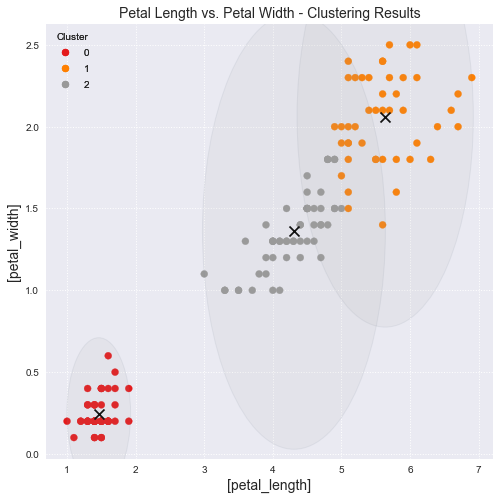

In [23]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
scatter = ax.scatter(iris.data[:,2], iris.data[:,3], c=labels.astype(np.float), cmap=plt.cm.Set1)

# prepare data legend
legend = ax.legend(*scatter.legend_elements(), loc='upper left', title='Cluster')

# add legend to plot
ax.add_artist(legend)

# plot cluster means
ax.scatter(means[:,0], means[:,1], marker='x', c='black', s=100)

# iterate over distinct cluster means
for i, mean in enumerate(means):
    
    # determine max cluster point distance
    cluster_radi = cdist(iris.data[:, 2:4][labels==i], [mean]).max()
    
    # plot cluster size
    ax.add_patch(plt.Circle(mean, cluster_radi, fc='darkgrey', edgecolor='slategrey', lw=1, alpha=0.1, zorder=1))

# add axis legends
ax.set_xlabel("[petal_length]", fontsize=14)
ax.set_ylabel("[petal_width]", fontsize=14)

# add plot title
plt.title('Petal Length vs. Petal Width - Clustering Results', fontsize=14);

In [24]:
#%%HTML
#<div align="middle">
#<video width="60%" controls>
#<source src="kmeansvideo.mp4" type="video/mp4">
#</video></div>

It can be observed that **k-Means Clustering algorithm** nicely found three clusters in the dateset. Let's inspect to which extend this corresponds to the true 'species' class labels 'verginica', 'setosa', and 'versicolor' of the iris dataset:

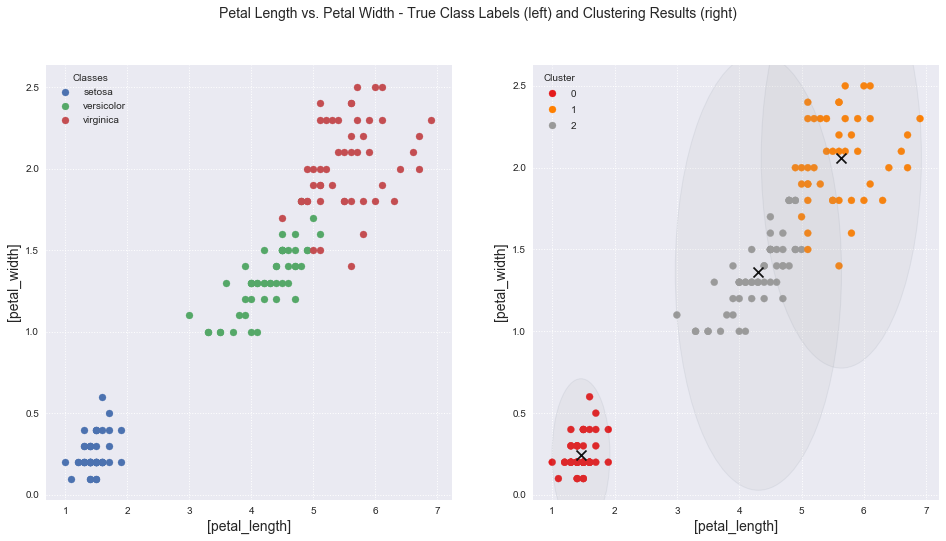

In [25]:
# init the plot
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

#### plot true iris class labels

# add grid
ax[0].grid(linestyle='dotted')

# iterate over distinct species
for species in np.unique(iris.target):
    
    # obtain iris petal length and petal width
    iris_features = iris.data[iris.target == species,:]
    
    # obtain iris species name
    iris_target_name = iris.target_names[species]
    
    # plot petal length vs. petal width as well as the true labels
    ax[0].scatter(iris_features[:,2], iris_features[:,3], c='C{}'.format(str(species)), label=iris_target_name)

# prepare data legend
ax[0].legend(loc='upper left', title='Classes')

# add axis legends
ax[0].set_xlabel("[petal_length]", fontsize=14)
ax[0].set_ylabel("[petal_width]", fontsize=14)

#### plot clustering results

# add grid
ax[1].grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
scatter = ax[1].scatter(iris.data[:,2], iris.data[:,3], c=labels.astype(np.float), cmap=plt.cm.Set1)

# prepare data legend
ax[1].legend(*scatter.legend_elements(), loc='upper left', title='Cluster')

# plot cluster means
ax[1].scatter(means[:,0], means[:,1], marker='x', c='black', s=100)

# iterate over distinct cluster means
for i, mean in enumerate(means):
    
    # determine max cluster point distance
    cluster_radi = cdist(iris.data[:, 2:4][labels==i], [mean]).max()
    
    # plot cluster size
    ax[1].add_patch(plt.Circle(mean, cluster_radi, fc='darkgrey', edgecolor='slategrey', lw=1, alpha=0.1, zorder=1))

# add axis legends
ax[1].set_xlabel("[petal_length]", fontsize=14)
ax[1].set_ylabel("[petal_width]", fontsize=14)

# add plot title
plt.suptitle('Petal Length vs. Petal Width - True Class Labels (left) and Clustering Results (right)', fontsize=14);

Ok, it seems that our clustering did a quite good job.

In addition, let's inspect the distance of all dataset records $X$ to their nearest means $\mu_{i}$. Let's recall that k-Means Clustering conducts a local optimization of the sum of "squared errors", as expressed by:

$$E(\mu_{1}, \mu_{2}, ..., \mu_{k}) = \sum_{i=1}^{n}(x_{i}-\mu_{k(i)})^{2},$$

were $x_{i}$ denotes a feature vector (or observation) of the dataset and $\mu_{k(i)}$ its closest mean in the feature space $\mathcal{R}^{d}$.

We can obtain the sum of those squared distances $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$ by calling the `inertia_` attribute of the learned k-Means Clustering model. It will return the sum of squared distances of each sample to its closest cluster center:

In [26]:
distances = kmeans.inertia_
print(distances)

31.437981063156826


### Exercises:

We recommend you try the following exercises as part of the lab:

**1. Train and evaluate the k-Means Clustering algorithm and obtain its assigned labels as well as squared distances $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$ for distinct max iterations.**

> Continuously increase the number of training iterations $i$ of the k-Means Clustering starting with 1 and up to 5 iterations ($i=1,...,5$) and repeat the clustering accordingly. What can be observed in terms of the cluster means as well as the sum of squared cluster distances with increasing $i$.

In [27]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**2. Determine if the k-Means Clustering algorithm always converges to the same result.**

> Carefully review the k-Means algorithm and answer to the following question: Does the k-Means algorithm always converge to the same result? Please, explain your reasoning.

In [28]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**3. Application of the k-Means Clustering algorithm to distinct data distributions.**

> Consider the following data distributions. Determine which are suitable for a k-Means clustering and what $k$ value should be applied in the clustering. Please, explain your reasoning.

<img align="center" style="max-width: 600px; height: auto" src="clustering.png">

In [29]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

### 1.4. k-Means Clustering in a 3-Dimensional Feature Space

Enable interactive 3-dimensional plotting inside of Jupyter notebooks:

In [30]:
%matplotlib notebook
from importlib import reload
reload(plt)

# import the seaborn plotting library
import seaborn as sns

# import matplotlibs 3D plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

We will now extend the k-Means Clustering to a 3-dimensional features space $\mathcal{R}^{3}$ space by clustering the first three features, namely `Sepal length (cm)`, `Sepal width (cm)`, and `Petal length (cm)` of the Iris dataset. Let's again start by visually inspecting the 3-dimensional feature space:

<IPython.core.display.Javascript object>


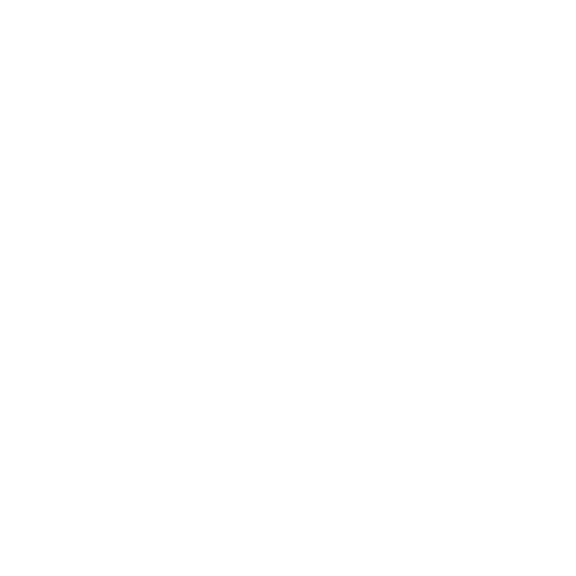

<IPython.core.display.Javascript object>


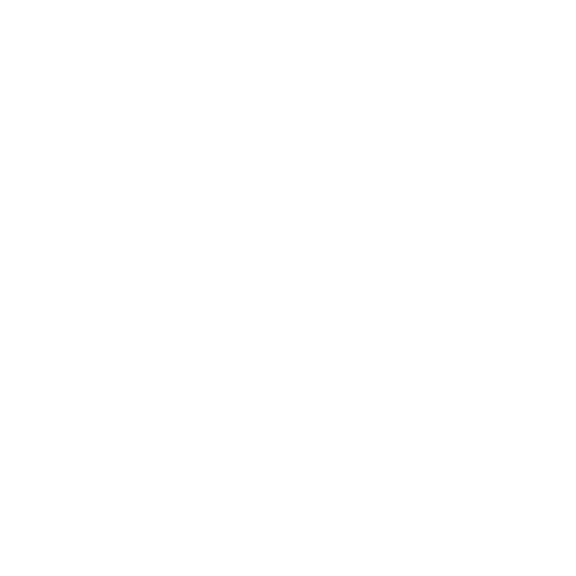

In [31]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# init 3D plotting
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=120)

# add grid
ax.grid(linestyle='dotted')

# plot petal length (3rd feature in the dataset) vs. petal width (4th feature in the dataset)
ax.scatter(iris.data[:,0], iris.data[:,1], iris.data[:,2], s=40)

# add axis legends
ax.set_xlabel("[sepal_length]", fontsize=14)
ax.set_ylabel("[sepal_width]", fontsize=14)
ax.set_zlabel("[petal_length]", fontsize=14)

# add plot title
plt.title('Sepal Length vs. Sepal Width vs. Petal Length', fontsize=14)

# show the 3-dimensional plot
plt.show();

We will start again by defining a **max. number of iterations** we aim to run the k-Means Clustering algorithm:

In [32]:
max_iterations = 10

Let's also initialize a corresponding number $k$ **initial random cluster 'means' $\mu_{i}$**. This time will specify $k=3$ cluster means each of dimension 3, since we aim to retrieve 3 clusters based on the 3 features `Sepal length (cm)`, `Sepal width (cm)`, and `Petal length (cm)`:

In [33]:
init_means = np.array([[1.0, 3.0, 3.0], [2.0, 6.0, 5.0], [1.0, 7.0, 2.0]])

Now, we ready to initialize an instance of the **k-Means Clustering** algorithm using Python's `sklearn` library of data science algorithms:

In [34]:
kmeans = KMeans(n_clusters=no_clusters, init=init_means, max_iter=max_iterations)

Let's run the k-Means Clustering to now learn a model of the `Sepal length (cm)`, `Sepal width (cm)`, and `Petal length (cm)` features. Pls. note that we are using columns 0, 1, and 2 to extract the values of the three features from the iris dataset:

In [35]:
kmeans.fit(iris.data[:,0:3]) # note that we are using column 1 (sepal length), 2 (sepal width) and 3 (petal length) 

KMeans(algorithm='auto', copy_x=True,
       init=array([[1., 3., 3.],
       [2., 6., 5.],
       [1., 7., 2.]]),
       max_iter=10, n_clusters=3, n_init=10, n_jobs=None,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

Let's again inspect the labels assigned to each individual record:

In [36]:
labels = kmeans.labels_ # obtain the assigned cluster labels
print(labels)           # print the cluster labels

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


As well as the determined cluster means:

In [37]:
means = kmeans.cluster_centers_ # obtain the assigned cluster means 
print(means)                    # print the cluster center coordinates

[[5.006      3.428      1.462     ]
 [5.86833333 2.74       4.38166667]
 [6.8525     3.07       5.6925    ]]


Let's also plot the iris dataset records using the three features `Sepal length (cm)`, `Sepal width (cm)` and `Petal length (cm)`, their corresponding learned labels as well as the cluster means as determined by the **k-Means Clustering** algorithm:

<IPython.core.display.Javascript object>


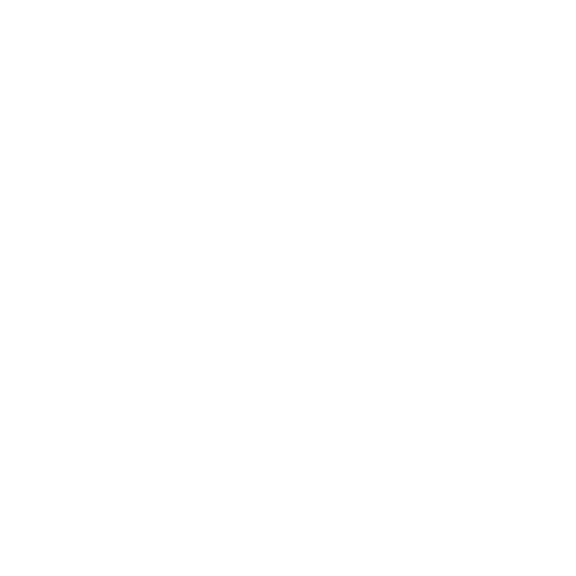

<IPython.core.display.Javascript object>


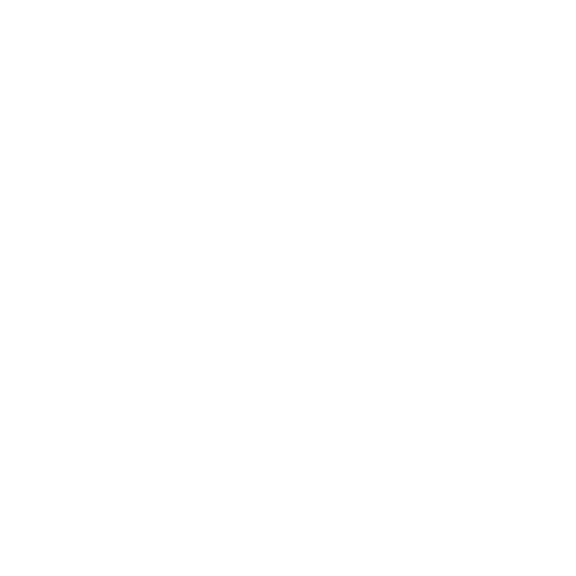

In [38]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# init 3D plotting
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=120)

# add grid
ax.grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
ax.scatter(iris.data[:,0], iris.data[:,1], iris.data[:,2], c=labels.astype(np.float), cmap=plt.cm.Set1, s=40)

# plot cluster means
ax.scatter(means[:,0], means[:,1], means[:,2], marker='x', c='black', s=100)

# add axis legends
ax.set_xlabel("[sepal_length]", fontsize=14)
ax.set_ylabel("[sepal_width]", fontsize=14)
ax.set_zlabel("[petal_length]", fontsize=14)

# add plot title
plt.title('Sepal Length vs. Sepal Width vs. Petal Length', fontsize=14);

# show the 3-dimensional plot
plt.show();

Finally, let's again inspect the distance of all dataset records $X$ to their nearest means $\mu_{i}$ by calling the `inertia_` attribute of the learned k-Means Clustering model:

In [39]:
distances = kmeans.inertia_
print(distances)

69.44196666666667


Enable inline Jupyter notebook plotting:

In [40]:
%matplotlib inline

### 1.5. Drawbacks of the k-Means Clustering Algorithm 

Even though the **k-Means Clustering** algorithm is one of the most popular clustering algorithms used in machine learning. There are three major drawbacks associated with it, which are explained hereafter:

1. The k-Means Clustering is guaranteed to improve the result in each iteration but there are **no guarantees** that it will find the **global best of clusters**. Recall the example, where we initalize the algorithm with a different seed of cluster means. 

> **Practical solution:** Run the algorithm with multiple random initializations. This also done per default when using the `scikit` learn of machine learning algorithms.

2. The k-Means Clustering **cannot learn** the **optimal number of clusters** from the provided data. E.g., if we ask the algorithm for 20 clusters it will find 20 clusters, which may or may not be meaningful. 

> **Practical solution:** Use the "Elbow" technique as explained in the next section of the notebook. Another option might be the usage of a more complex clustering algorithm like Gaussian Mixture Models, or one that can choose a suitable number of clusters, e.g., the DBSCAN clustering algorithm.

3. The k-Means Clustering **doesn't work well** in instances of a **non-linear seperable** dataset. This is caused by its assumption that points will be closer to their own cluster center than to others.

> **Practical solution:** Transform (if possible) the dataset into a higher dimension where a linear separation becomes possible, e.g., by using a spectral clustering algorithm.

### 1.6. Optimal Cluster Number Detection

Recall that, one of the basic ideas behind unsupervised machine learning methods, such as **k-Means clustering**, is to define clusters for which the total intra-cluster variation (usually measured by the total sum of squared distances) is minimized:

$$k^{*} =\underset{k}{\arg \min} \sum_{i=1}^{n}(x_{i}-\mu_{k(i)})^{2},$$

were $x_{i}$ denotes a single feature vector (or observation) in the dataset and $\mu_{k(i)}$ its closest mean in the feature space $\mathcal{R}^{d}$. Challenge: What is the optimal number of clusters $k$ for a given dataset? Selection of the right $k$ may result in the following issues:

- if $k$ too small (under-segmentation), then the clusters are too diverse; and;
- if $k$ too high (over-segmentation), then the clusters are too fine-grain.

Examples: 

<img align="center" style="max-width: 800px; height: auto" src="kselection.png">

Solution: We can then use the sum of "squared errors" $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$ metric to find an optimal number of clusters $k$! This can be achieved by the execution of the so-called **'Elbow'** technique defined by the following algorithm:

>- **Step 1** - Compute the k-Means clustering algorithm for different number of clusters $k$.
>- **Step 2** - For each $k$ calculate the sum of the within-cluster sum of squared distances $E(\mu_{1}, \mu_{2}, ..., \mu_{k})$.
>- **Step 3** - For each $k$ plot the $k$ value vs. its corresponding sum of within-cluster sum of squared distances $E$. 
>- **Step 4** - Inspect the plot and determine the location of a bend (appropriate number of clusters).

Let's utilize the **'Elbow'** technique by first defining a max. number of iterations that we aim to apply at each k-Means clustering run:

In [41]:
max_iterations = 100

Now we can implement the and run the 'elbow' technique:

In [42]:
# init the list of squared distances
sum_of_squared_distances = []

# define the range of k-values to investigate
K = range(1,30)

# iterate over all k-values
for k in K:
    
    # init the k-Means clustering algorithm of the current k-value
    kmeans = KMeans(n_clusters=k, init='random', max_iter=max_iterations)
    
    # run the k-Means clustering of sepal-length and sepal-width features
    kmeans = kmeans.fit(iris.data[:,0:2])
    
    # collect the sum of within squared distances of the current k-value
    sum_of_squared_distances.append(kmeans.inertia_)

Upon completion of the loop above let's inspect the distinct within-cluster sum of squared distances $E$:

In [43]:
# print the collected sum of squared distances of each k
sum_of_squared_distances

[130.47526666666667,
 58.20409278906671,
 37.05070212765958,
 27.966379045865935,
 21.00212598224944,
 17.42559768907563,
 15.089569264069265,
 12.788763481527546,
 11.395370454545459,
 9.709481962481963,
 8.821254256854257,
 7.859130907491203,
 7.322548035298038,
 6.60576848559937,
 6.424281746031746,
 5.583388805638808,
 5.158858691961635,
 4.897361222111221,
 4.886450105450106,
 4.30543253968254,
 4.282002164502165,
 4.09032142857143,
 3.9108546176046186,
 3.53009126984127,
 3.515766483516484,
 3.2347043650793648,
 2.9378931623931632,
 2.804623321123321,
 2.8875518925518926]

Furthermore, let's plot the cluster number $k$ vs. the within-cluster sum of squared distances $E$:

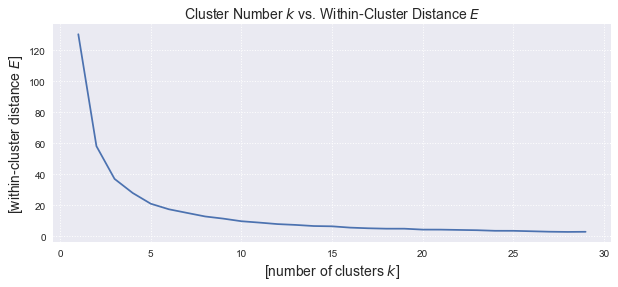

In [44]:
# init the plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length (3rd feature in the dataset) vs. petal width (4th feature in the dataset)
ax.plot(K, sum_of_squared_distances)

# add axis legends
ax.set_xlabel("[number of clusters $k$]", fontsize=14)
ax.set_ylabel("[within-cluster distance $E$]", fontsize=14)

# add plot title
plt.title('Cluster Number $k$ vs. Within-Cluster Distance $E$', fontsize=14);

### Exercises:

We recommend you to try the following exercises as part of the lab:

**1. Apply the k-Means Clustering algorithm to all four features contained in the Iris dataset.**

> Use the k-Means classifier to learn a model of all four features contained in the Iris dataset, namely `Sepal length (cm)`, `Sepal width (cm)`, `Petal length (cm)` and `Petal width (cm)`.

In [45]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**2. Determine the optimal number of cluster values $k$ of all four features contained in the iris dataset.**

> Determine the optimal number of clusters $k$ needed to cluster the observations of all four features contained in the iris dataset using the **'Elbow'** technique outlined above.

In [46]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

## 2. Unsupervised Machine Learning: Expectation Maximization

"One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster" (Jake VanderPlas, The Python Data Science Handbook). To investigate this further let's have a closer look at another very skewed data distribution. 

### 2.1. Dataset Creation and Data Assessment

Let's create a very skewed distribution that exhibits a eliptical characteristic:

In [47]:
# generate a sample data distribution
data, labels = make_blobs(n_samples = 1000, centers = 3, cluster_std = .7, random_state = 0)

# init the random state and skew the data
random_state = np.random.RandomState(8)
data_skewed = np.dot(data, random_state.randn(2, 2))

Once created, let's visualize the skewed distribution accordingly:

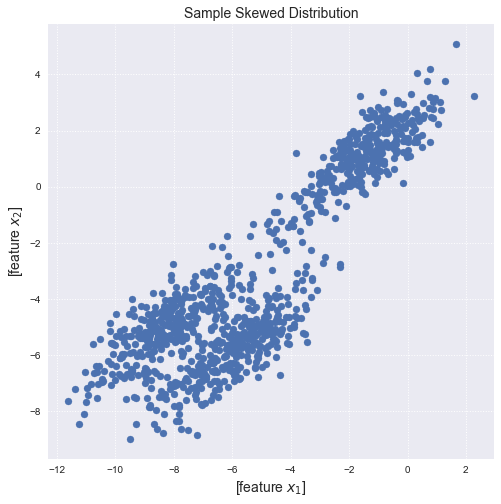

In [48]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the two dimensions of the skewed distribution
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1])

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution', fontsize=14);

Ok, the distribution looks indeed very skewed. It furthermore seem to consist of three commingled eliptical clusters. Let's see if we can identify those clusters using the k-Means Clustering algorithm that we discussed before:

In [49]:
# init the k-Means Clustering algorithm
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=100)

# fit the clustering to the the data
kmeans.fit(data_skewed)

# obtain the cluster labels
kmeans_labels_skewed = kmeans.labels_

# obtain the cluster means
kmeans_means_skewed = kmeans.cluster_centers_

Let's now visualize the results of the clustering as well as the obtained clusters:

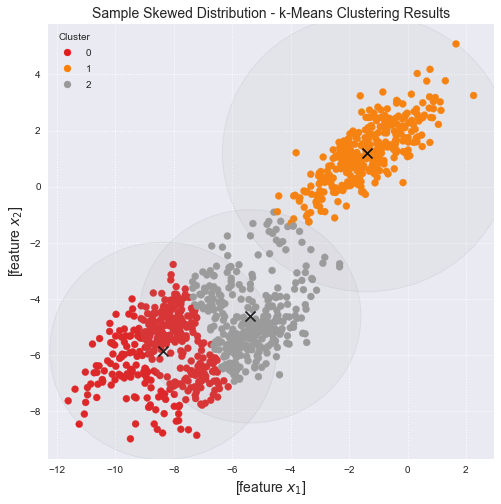

In [50]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1], c=kmeans_labels_skewed.astype(np.float), cmap=plt.cm.Set1)

# prepare data legend
ax.legend(*scatter.legend_elements(), loc='upper left', title='Cluster')

# plot cluster means
ax.scatter(kmeans_means_skewed[:,0], kmeans_means_skewed[:,1], marker='x', c='black', s=100)

# iterate over distinct cluster means
for i, mean_skewed in enumerate(kmeans_means_skewed):
    
    # determine max cluster point distance
    cluster_radi = cdist(data_skewed[:, 0:2][kmeans_labels_skewed==i], [mean_skewed]).max()
    
    # plot cluster size
    ax.add_patch(plt.Circle(mean_skewed, cluster_radi, fc='darkgrey', edgecolor='slategrey', lw=1, alpha=0.1, zorder=1))

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution - k-Means Clustering Results', fontsize=14);

Based on the example above we observe one of the main disadvantages of the k-Means Clustering algorithm. k-Means Clustering has no way to account for oblong or elliptical clusters. Therefore, it fails to recognize the distinct clusters in very skewed distributions.

### 2.2. The Expectation Maximization (EM) Algorithm

The **Expectation Maximization (EM)** algorithm technique is similar to the k-Means Clustering technique. However, instead of assigning examples to clusters to maximize the differences in means for continuous variables, the EM Clustering algorithm computes probabilities of cluster memberships based on one or more probability distributions. The goal of the clustering algorithm then is to maximize the overall probability or likelihood of the data, given the (final) clusters. Thereby, the objective of EM clustering is to estimate the means and standard deviations for each cluster so as to maximize the likelihood of the observed data (distribution). To achieve this objective the algorithm iteratively computes an (1) Expectation-Step and (2) Maximization-Step as described in the following:

#### Step-1: The Expectation-Step

In the **"Expectation Step"** we determine the expected values $E(z_{ij} | \mu_{j}^{t}, \sigma_{j}^{t})$ that denotes the probability of a given observation $x_i \in \mathcal{R}^d$ that it was drawn from the $j^{th}$ distribution (or cluster):

$$E(z_{ij}) = \frac{P(x_i|\mu_{j}^{t}, \sigma_{j}^{t})}{\sum_{k'=1}^k P(x_i|\mu_{k'}^{t},\sigma_{k'}^{t})},$$

were:

- $x_i \in X$ denotes a particular data observation;
- $t$ denotes the current iteration of the EM Clustering algorithm;
- $\mu_j$ and $\sigma_j$ denotes the mean and variance of the $j^{th}$ distribution (or cluster).

During the lecture you learned that the probability distribution of each cluster might be approximated by a Gaussian (Normal) probability distribution $\mathcal{N}(\mu, \sigma)$. This simplification is justified by the application of the **"law of large numbers"** or **"Central Limit Theorem"** (you may want to have a look at further details of the theorem under: https://en.wikipedia.org/wiki/Central_limit_theorem). In general, the probability density of a Gaussian "Normal" distribution, as defined by the formula below. It is parametrized its mean $\mu$ and corresponding standard deviation $\sigma$:

$$ P(x|\mu,\sigma)  \approx \mathcal{N}(x|\mu, \sigma) = e^{-\frac{1}{2\sigma^{2}}(x - \mu)^2}$$

Using the **Central Limit Theorem** we can rewrite the formula of the Expectation Step as:

$$E(z_{ij}) = \frac{P(x_i|\mu_j^{t}, \sigma_j^{t})}{\sum_{k'=1}^k P(x_i|\mu_{k'}^{t},\sigma_{k'}^{t})} = \frac{\mathcal{N}(x_i|\mu_j^{t}, \sigma_j^{t})}{\sum_{k'=1}^k \mathcal{N}(x_i|\mu_{k'}^{t},\sigma_{k'}^{t})} = \frac{ e^{-\frac{1}{2\sigma_{j}^{t 2}}(x_i - \mu_{j}^{t})^2} }{ \sum_{k'=1}^{k}e^{-\frac{1}{2\sigma_{k'}^{t 2}}(x_i - \mu_{k'}^{t})^2} }$$

The distinct $E(z_{ij})$ values $z_{1j}$, $z_{2j}$, ..., $z_{nj}$ represent the probability distribution of the $j^{th}$ cluster that the data point is drawn from. Understanding the range of values the $z$ values can take is important. Each observation $x_i$ has k associated $E(z_{ij})$ values. In the **k-Means Clustering** algorithm each $z_{ij}$ can only take the value 0 or 1. This is why the k-Means Clustering algorithm is referred to as **"hard"** clustering.

In contrast, the **"EM-Clustering"** algorithm is referred to as **"soft"** or **"fuzzy"** clustering. In EM-Clustering the distinct observations $x_i$ are considered to be drawn probabilistically from the distinct cluster distributions $j$. The corresponding $z_{ij}$ values can therefore be $z_{i1}$=0.85, $z_{i2}$=0.10 and $z_{i3}$=0.05, which represents a strong probability that the $x_{i}$ value originates from distribution (or cluster) 1 and a exhibit a smaller probability that it originates from distribution (or cluster) 2 or 3.

#### Step-2: The Maximization-Step

In the **"Maximization-Step"** we calculate update the parameters of each Gaussian "Normal" cluster distribution. Therefore, we derive for each $j^{th}$ distribution (or cluster) a new $\mu_{j}$ and $\sigma_{j}$ parameter value as given by:

$$ \mu_{k}^{t+1} = \frac {\sum_{k'=1}^{k}E(z_{ij})x_i} {\sum_{k'=1}^{k}E(z_{ij})}; \sigma_{j}^{2, t+1} = \frac {\sum_{k'=1}^{k}E(z_{ij}) (x_i - \mu_{k}^{t})^{2}} {\sum_{k'=1}^{k}E(z_{ij})}$$

### Expectation Maximization (EM) in a 2-Dimensional Feature Space

Similarly, to k-Means Clustering let's now define the parameters of the **EM-Clustering** algorithm. We will start by specifying the **number of clusters** $k$ we aim to detect in the iris dataset. We again hypothesize that our observations are drawn from an unknown distributions of three iris flower species (each distribution corresponding to a different mean $\mu_1$, $\mu_2$, and, $\mu_3$ and corresponding standard deviation $\sigma_1$, $\sigma_2$, and, $\sigma_3$). Therefore, we set the number of clusters to be detected to $k=3$:

In [51]:
no_clusters = 3

Next, we need to define a corresponding number of **initial 'means' $\mu_{i}$** (the initial random cluster centers) that will be used as 'starting points' in the first iteration of the clustering process. In our case we will specify $k=3$ cluster means each of dimension 2, since we aim to retrieve 3 clusters based on the 2 features $x_1$ and $x_2$:

In [52]:
init_means = np.array([[1.0, 3.0], [2.0, 6.0], [1.0, 7.0]])

Finally, we will define a **maximum number of iterations** that we want to run the **EM-Clustering** algorithm. Please, note that the clustering terminates once there will be no further changes in the cluster assignments. However, it's good practice to define an upper bound of the iterations applied in the clustering (especially when analyzing datasets that exhibt a high-dimensional feature space):

In [53]:
max_iterations = 50

Now, we ready to initialize an instance of the **EM-Clustering** algorithm using Python's `sklearn` library of data science algorithms:

In [54]:
em = GaussianMixture(n_components=no_clusters, means_init=init_means, max_iter=max_iterations)

Let's run the **EM-Clustering** to learn a model of the $x_1$ and $x_2$ features. Similar to the k-Means Clustering we will again make use of the `fit()` method provided by `sklearn` for each of its classifiers:

In [55]:
em.fit(data_skewed)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=50,
                means_init=array([[1., 3.],
       [2., 6.],
       [1., 7.]]),
                n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now that we have conducted the clustering, let's inspect the distinct cluster labels that have been assigned to the individual records of our artificial dataset. This can be achieved by calling the `predict()` function of the fitted model: 

In [56]:
em_labels_skewed = em.predict(data_skewed)

Furthermore, we want to inspect the coordinates of the cluster means (sometimes also referred to as "centroids") assigned by the algorithm. This can be achieved by calling the `means_`attribute of the fitted model:

In [57]:
em_means_skewed = em.means_ 

Let's now visually inspect the clustering results of the two features $x_1$ and $x_2$ in terms of the cluster assignments of each observation and cluster means learned by the **EM-Clustering** algorithm:

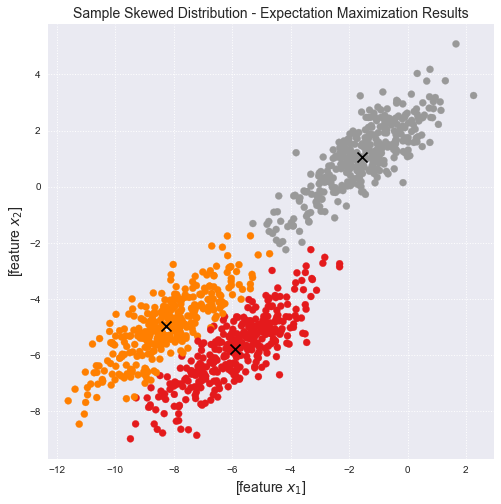

In [58]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot x_1 vs. x_2 and corresponding cluster labels
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1], c=em_labels_skewed.astype(np.float), cmap=plt.cm.Set1)

# plot cluster means
ax.scatter(em_means_skewed[:,0], em_means_skewed[:,1], marker='x', c='black', s=100)

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution - Expectation Maximization Results', fontsize=14);

Ok, we can observe that the EM Clustering technique nicely clusters the distinct distributions of the skewed distributions. We notice that the results are quite different from those computed by the k-Means clustering. As initially stated, the EM Clustering determines the **probability of cluster memberships** for each observation based on the initially specified $k$ probability distributions. Let's obtain those probabilites for each observation using the `predict_proba()` function:

In [59]:
em_probabilities_skewed = em.predict_proba(data_skewed)

Let's now visually inspect the clustering results of the two features $x_1$ and $x_2$ in terms of the learned probabilities of each observation corresponding to a particular cluster as determined by the **EM-Clustering** algorithm:

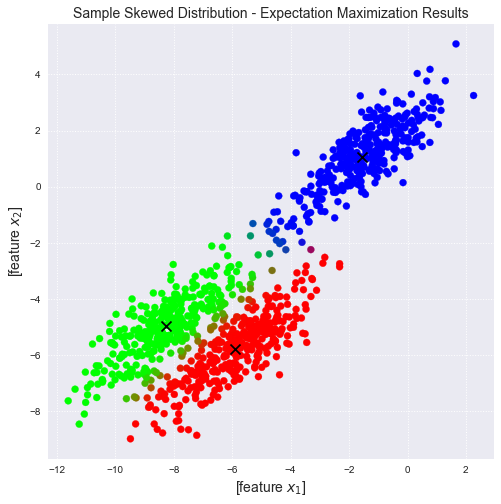

In [60]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot x_1 vs. x_2 and corresponding cluster labels
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1], c=em_probabilities_skewed.astype(np.float), cmap=plt.cm.Set1)

# plot cluster means
ax.scatter(em_means_skewed[:,0], em_means_skewed[:,1], marker='x', c='black', s=100)

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution - Expectation Maximization Results', fontsize=14);

It can be observed that the EM-Clustering algorithm conducts a **"soft"** or **"fuzzy"** cluster assignment especially for observations that reside at the edges of the distinct clusters.

### Lab Summary:

In this fourth lab, a step by step introduction into the unsupervised **k-Means Clustering** and **EM-Clustering** machine learning algorithms was presented. The code and exercises presented in this lab may serve as a starting point for more complex and tailored programs.

You may want to execute the content of your lab outside of the Jupyter notebook environment, e.g. on a compute node or a server. The cell below converts the lab notebook into a standalone and executable python script. Pls. note that to convert the notebook, you need to install Python's **nbconvert** library and its extensions:

In [61]:
# installing the nbconvert library
!pip install nbconvert
!pip install jupyter_contrib_nbextensions

/bin/sh: pip: command not found
/bin/sh: pip: command not found


Let's now convert the Jupyter notebook into a plain Python script:

In [62]:
!jupyter nbconvert --to script aiml_lab_04.ipynb

[NbConvertApp] Converting notebook aiml_lab_04.ipynb to script
[NbConvertApp] Writing 40871 bytes to aiml_lab_04.py
